# Credit Card Fraud Classification using Adaptive Synthetic Sampling approach and Logisitc Regression

In [37]:
import os
os.chdir('D:/Ubuntu/CreditCardFraud/') #Set working directory
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import datetime
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, validation_curve
from sklearn.metrics import *
from itertools import cycle


from imblearn.over_sampling import ADASYN

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# Read credit card fraud data
cc_fraud = pd.read_csv('./Data/creditcard.csv')
print("Number of instances: %d" % cc_fraud.shape[0])
print("Number of features: %d" % cc_fraud.shape[1])
cc_fraud.head()

Number of instances: 284807
Number of features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
cc_fraud.Class.value_counts()*100/cc_fraud.shape[0]

0    99.827251
1     0.172749
Name: Class, dtype: float64

To deal with high class imbalance, we perform oversampling. The technique used to perform over sampling is discussed in the following section.

## Adaptive Synthetic Sampling (ADASYN)
Over-sampling using Adaptive Synthetic Sampling Approach. According to the [ADASYN paper](http://ieeexplore.ieee.org/document/4633969/?part=1), **ADASYN generates synthetic samples that are difficult to classify**, so that our machine learning model is able to learn more about the difficult samples. 

The idea of the algorithm is as follows - 
- Compute the class imbalance ratio 
- Calculate the total number of synthetic samples that need to be generated for the minority class. (G)
- For each of the minority sample, compute **K** nearest neighbours based on the Euclidean distance in the n-dimensional space and calculate the ratio $r_i$ as $$r_i = \frac{\Delta_i}{K}$$
where $\Delta_i$ is the number of samples in the **K** nearest neigbours that belong to the majority class.
- Normalize $r_i$ so that get a density distribution
- Calculate the number of synthetic samples that need to be generated for each of the minority samples
- For each of the minority samples, create synthetic samples in the following manner: $$s_i = x_i +(x_z - x_i)*\lambda$$
    - $x_z$: Randomly selected minority sample
    - $(x_z - x_i)$: Difference between the samples in the n-dimensional space
    - $\lambda$: Random number between $[0,1]$

Let's create synthetic samples using only the **PCA features.**

In [4]:
%%time
ros = ADASYN(n_neighbors = 10, ratio = 'auto', random_state=123,n_jobs = -1)

X = cc_fraud.drop(['Class', 'Time', 'Amount'], axis = 1)
y = cc_fraud['Class']

# X_data = np.array(X_data)
# y_data = np.array(y_data)

X_ros, y_ros = ros.fit_sample(X, y)
print('Original data shape: {}'.format(Counter(y)))
print('Reshaped data shape: {}'.format(Counter(y_ros)))

Original data shape: Counter({0: 284315, 1: 492})
Reshaped data shape: Counter({0: 284315, 1: 284297})
Wall time: 3h 19min 48s


### Visualize ADSYN based on first two features

In [5]:
import matplotlib.patches as mpatches

def scatter_plot_data(df, ax, title):
    c = df.iloc[:,2].map({0:'b',1:'black'})
    class_markers = df.iloc[:,2].map({0:'o',1:'<'})
    i = 0
    j = 0
    for _f1,_f2,c,cm,lb in zip(df.iloc[:,0],df.iloc[:,1],c,
                               class_markers,df.iloc[:,2]):
        if lb == 1:
            ax.scatter(_f1,_f2,marker = cm,c = c,s = 60,label = 'Class_1' if i == 0 else '')
            i +=1
        elif lb == 2:
            ax.scatter(_f1,_f2,marker = cm,c = c,s = 60,label = 'Class_2' if j == 0 else '')
            j +=1
    ax.set_title(title,size = 30)
    ax.set_xlabel('Feature 1',size = 20)
    ax.set_ylabel('Feature 2',size = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(loc=0,prop={'size':15})

temp_df = pd.DataFrame(data = list((X_ros[:,0],X_ros[:,1],y_ros))).T
temp_df.columns = ['V1','V2','Class']
temp_df.head()

,V1,V2,Class
0,-1.359807,-0.072781,0.0
1,1.191857,0.266151,0.0
2,-1.358354,-1.340163,0.0
3,-0.966272,-0.185226,0.0
4,-1.158233,0.877737,0.0


KeyboardInterrupt: 

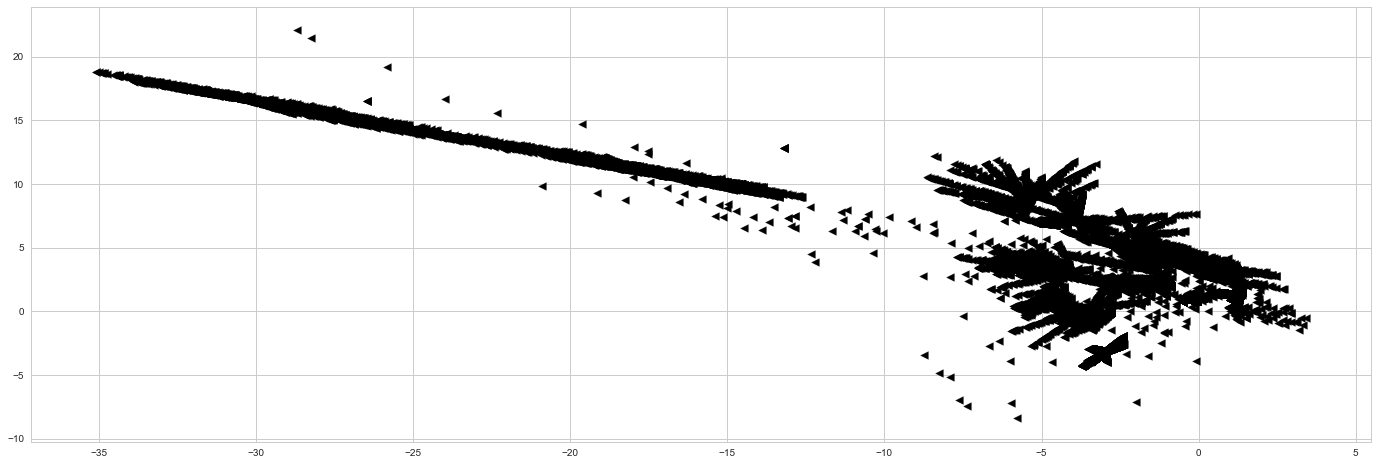

In [7]:
f, ax = plt.subplots(1, 1, sharey=False, figsize=(24,8))

scatter_plot_data(temp_df,ax,"Scatter Plot")

## Simple Logistic Regression

Logistic regression is a probabilistic model that models a binary response variable based on different explanatory variables. It has the following advantages - 

1. Easy model to implement and interpret. The weights help us explain the effect of individual explanatory variables on the response variable.

2. Although it is generally used for binary response variables, it can be extended to multiclass classification using 'one-vs-rest' methodology. In one-vs-all methodology, *K* binary classifiers are built for *K-class* classification. A given sample is assigned to the class for which it has been assigned the maximum probability.

3. Performs well on linearly seperable cases.

### Understanding Logistic Regression

To understand logistic regression, let's start with defining odds ratio.

$ Odds Ratio = \frac{p}{1-p} $

where p = the probability of the event of interest. e.g - probability of a patient surviving

Taking the log of the odds ratio, logit(p) is defined as

$logit(p) = log{\frac{p}{1-p}}$

which can be further expressed in linear form as

$ logit(p(y=1|x)) = w_0 + w_1x_1 + ... + w_mx_m = \sum_{i=1}^{m} {w_ix_i} = W^TX $

where, 
    * p(y=1|x) = conditional probability of a sample belonging to class 1
    * m = number of samples
    * X = explanatory features
    * W = weights

Using this information, we can now compute $p(y=1 | x)$. 

To compute, we need to compute the inverse of the logit function, which also known as logistic or the sigmoid function. It is defined as follows  

$ \phi(z) = \frac{1}{1+e^{-z}} $

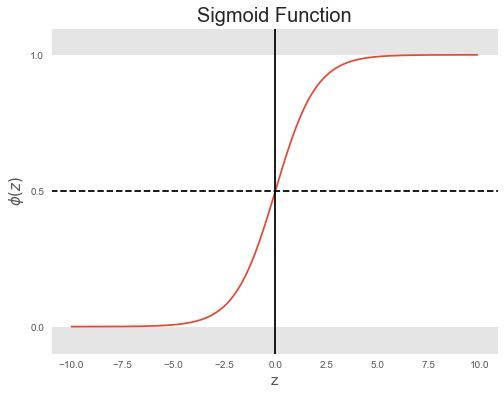

In [8]:
def sigmoid(z):
    return (1.0/(1.0+np.exp(-z)))
z = np.arange(-10,10,0.1)
phi_z = sigmoid(z)
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.axhspan(0.0,1.0,facecolor='1.0',alpha=1.0, ls='--')
plt.axhline(y=0.5,ls='--',color='k')
plt.yticks([0.0,0.5,1.0])
plt.ylim(-0.1,1.1)
plt.xlabel('z', fontsize=15)
plt.ylabel('$\phi(z)$', fontsize=15)
plt.title('Sigmoid Function', fontsize=20)
plt.grid('off')

From the above plot, we can see that $lim_{z\to\infty} {\phi(z)} = 1$ and $lim_{z\to-\infty} {\phi(z)} = 0$. Hence, the sigmoid function takes real numbers as input and transforms them into the range [0,1] with an intercept at $\phi(z) = 0.5$. This is convenient in terms of modeling probabilities. Hence, the predicted output can be written as,

$\hat{y} = 
\left\{
		\begin{array}{ll}
				1 & \mbox{if } \phi(z) \geq 0.5\\
				0 & \mbox otherwise
		\end{array}
\right.$

or

$\hat{y} = 
\left\{
		\begin{array}{ll}
				1 & \mbox{if } z\geq0\\
				0 & \mbox otherwise
		\end{array}
\right.$

Therefore, we have

$ P(Y=1|X) = \frac{1}{1+exp(-W^TX)} $

and

$ P(Y=0|X) = \frac{exp(W^TX)}{1+exp(W^TX)} $

From the above equation, the linear classification rule can be defined as 

$ ln\frac{P(Y=0|X}{P(Y=1|X} = w_0 + W^TX $


### Training logistic regression

Sum-squared error as the cost function for the model is defined as 

$ J(w) = \sum_{i} {\frac{1}{2} ({\phi (z^{i}) - y^{i}})^2} $

We need to maximize the likelihood of sample *x* belonging to class *k*. Therefore,

$ L(w) = P(y|x;w) = \prod_{i=1}^{N} P(y^{i}|x^{i},w) = \prod_{i=1}^{N} (\phi(z^{i})^{y^{i}}) (1-\phi(z^{i}))^{1-y^{i}}$

The conditional log-likelihood then can be defined as

$ l(w) = \sum_{i=1}^{N} [({y^{i}}\phi(z^{i})) + (1-y^{i})(1-\phi(z^{i}))]$

MLE for logistic regression is given by

$ w_{MLE} = \underset{w}{\operatorname{argmax}}  \sum_{i=1}^{N} [({y^{i}}\phi(z^{i})) + (1-y^{i})(1-\phi(z^{i}))]$

In words, we can say that, given a training set, we would like to find a set of parameters or weights such that $ P(y=1|x) $ is close to $1$ for a positive sample and is close to 0 otherwise.

The function can be looked from optimization point of view. 

## Train Logistic Regression for Credit Card Data

We are using only the **PCA features.**

### Model selection and cross-validation strategy

We will use train data to train our logistic regression model and a fraction of the training data as the validation data to select the regularization parameter for the model. After selecting our model based on the validation performance, we will check the performance on test data.

**Stratified k-fold cross validation** creates folds of train and test/validation data by maintaining the class distribution in each of the fold, thus each fold representing the class distribution of the population or the training data in this case.

In [29]:
#Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size = 0.4, random_state = 735215)

# Define stratified k-fold cross validation object

K = 10 #Number of folds for cross validation
stratified_cv = StratifiedShuffleSplit(n_splits = K, random_state = 489567)

### L2 Regularization Parameter Sweep

In [47]:
# Reference - http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
def plot_val_curve(train_scores, val_scores, param_range, plt_title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(14,6))
    
    plt.title(plt_title)
    plt.xlabel("$C-Regularization parameter$")
    plt.ylabel("Accuracy")
#     plt.ylim(0.0, 1.1)
    
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    plt.semilogx(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.3min finished


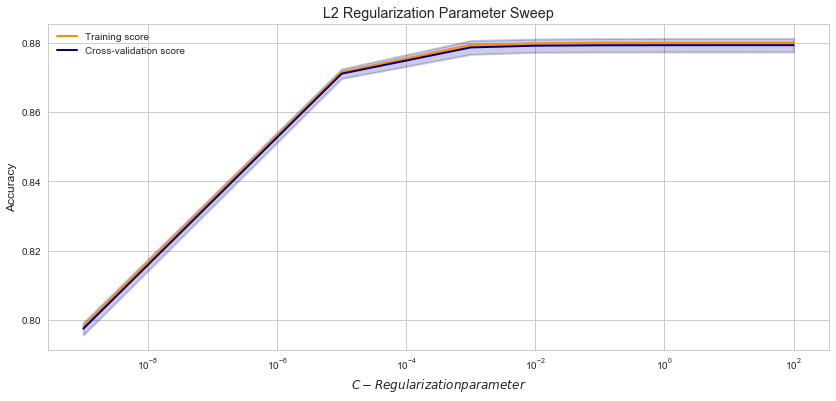

In [55]:
clf_LR_L2 = LogisticRegression(penalty='l2', solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)
param_C_range = [1e-9, 1e-5, 1e-3, 1e-2, 1e-1, 1.0,10,100]
train_scores, val_scores = validation_curve(estimator=clf_LR_L2, 
                                            X=X_train, 
                                            y=y_train, 
                                            param_name='C', 
                                            param_range=param_C_range,
                                            cv=stratified_cv,
                                            n_jobs=-1,
                                            verbose=1,
                                            scoring='accuracy')

# Average precision corresponds to the area under the precision recall curve

plot_val_curve(train_scores, val_scores, param_C_range, plt_title='L2 Regularization Parameter Sweep')
plt.xscale('log')
plt.show()

### L1 Regularization Parameter Sweep

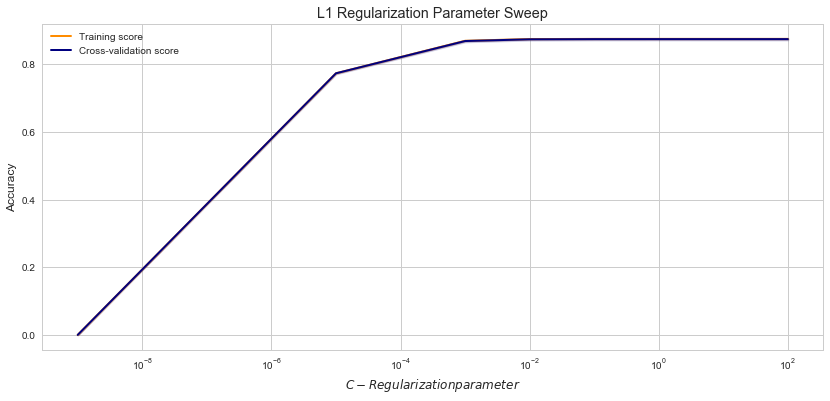

In [57]:
clf_LR_L1 = LogisticRegression(penalty='l1', solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)
param_C_range = [1e-9, 1e-5, 1e-3, 1e-2, 1e-1, 1.0,10,100]
train_scores, val_scores = validation_curve(estimator=clf_LR_L1, 
                                            X=X_train, 
                                            y=y_train, 
                                            param_name='C', 
                                            param_range=param_C_range,
                                            cv=stratified_cv,
                                            n_jobs=-1,
                                            scoring='f1')

plot_val_curve(train_scores, val_scores, param_C_range, plt_title='L1 Regularization Parameter Sweep')
plt.xscale('log')
plt.show()

### Logistic Regression - Learning curve

Reference - http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [ ]:
# Learning Curve

def plot_learning_curve(X,y,clf_estimator, cv_estimator, scorer, groups, xlabel=''):
    train_x_axis, train_scores, test_scores =learning_curve(estimator=clf_estimator,
                                                           X=X,
                                                           y=y,
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=cv_estimator,
                                                           scoring=scorer,
                                                           exploit_incremental_learning=True,
                                                           groups=user,
                                                           n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()

clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=500)


plot_learning_curve(X_train, y_train, clf_LR, , xlabel='Number of training samples')

In [ ]:
#Reference - http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn import metrics as mt
from scipy import interp


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
clf_LR_metrics = list()

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0

for (train_idx, val_idx), color in zip(stratified_cv.split(X, y), colors):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    n_classes = np.unique(y_train) #Get total classes 
    
    #Define and fit a logistic regression classifier
    clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                               random_state=178926, n_jobs=-1, max_iter=500)
    clf_LR.fit(X_train, y_train)
    
    #Predict class label and probability for the validation data set
    y_pred = clf_LR.predict(X_val)
    y_prob = clf_LR.predict_proba(X_val)
    
    #Compute classification metrics
    acc = mt.accuracy_score(y_val, y_pred)
    precision = mt.precision_score(y_val, y_pred)
    recall = mt.recall_score(y_val, y_pred)
    f1_score = mt.f1_score(y_val, y_pred)
    logloss = mt.log_loss(y_val, y_pred)
    
    #Compute sensitivity, specificity and ROC for different levels of thresholds
    fpr, tpr, thresholds = roc_curve(y_val, y_prob[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    i +=1 #Counter for validation fold
    
    clf_LR_metrics.append([acc, precision, recall, f1_score, logloss, roc_auc])

# Luck
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

#Summary of classification performance
clf_LR_metrics = pd.DataFrame(clf_LR_metrics, columns=['Accuracy','Precision','Recall','F1_Score','LogLoss','AUC'])

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Accuracy), np.std(clf_LR_metrics.Accuracy)))
print('\nCV Precision: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Precision), np.std(clf_LR_metrics.Precision)))
print('\nCV Recall: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Recall), np.std(clf_LR_metrics.Recall)))
print('\nCV F1_Score: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.F1_Score), np.std(clf_LR_metrics.F1_Score)))
print('\nCV LogLoss: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.LogLoss), np.std(clf_LR_metrics.LogLoss)))
print('\nCV AUC: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.AUC), np.std(clf_LR_metrics.AUC)))

In [ ]:
clf_LR_metrics

In [ ]:
clf_LR.coef_